In [2]:
import pandas as pd
import numpy as np

vals = np.array([[0, 1, 1, 2]])
relation = pd.DataFrame(vals, columns=["source","target","lag","weight"])

import networkx as nx

G = nx.DiGraph()
for _, row in relation.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

relation.to_csv('../Experiments/Sythetic_DAG_data/synth_data_back_door_relation.csv', index=False) 

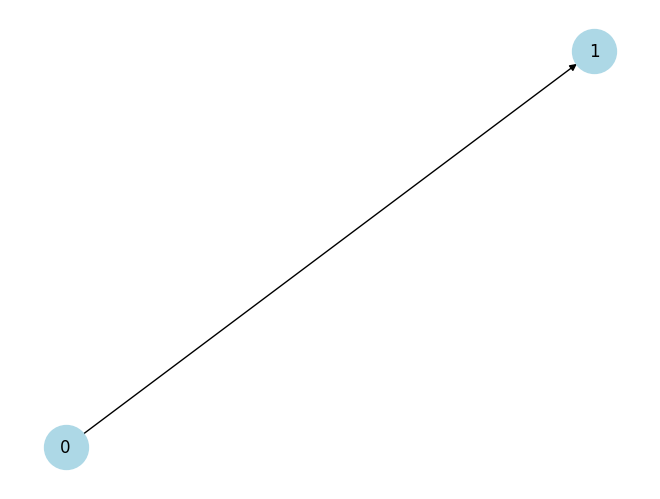

In [3]:
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True, node_color="lightblue", node_size=1000, font_size=12)
plt.show()

In [4]:
for i in G.nodes:
    print(i)

0
1


In [5]:
G[0][1]

{'weight': np.int64(2)}

In [ ]:
seed = 0
np.random.seed(seed)
#y_t = lambda y_t_1, e: .8*y_t_1 + e

all_x = [np.random.normal(0,1)]
all_y = [np.random.normal(0,1)]

for t in range(1, 10000):
    theta_x, sigma_x = 0.2, 0.5
    theta_y, sigma_y, beta = 0.3, 0.6, 0.5

    x_t = lambda x_prev, eta: x_prev - theta_x * x_prev + sigma_x * eta
    y_t = lambda x_prev, y_prev, eps: y_prev - theta_y * y_prev + beta * x_prev + sigma_y * eps

    
    all_x.append(x_t(all_x[-1], np.random.normal(0,1)))
    all_y.append(y_t(all_x[-2], all_y[-1], np.random.normal(0,1)))

data = pd.DataFrame([all_x, all_y]).T
synth_data = pd.DataFrame(data)
synth_data.to_csv('../Experiments/Sythetic_DAG_data/synth_data_back_door.csv', index=False)

In [31]:
synth_data

,0,1
0,1.764052,0.400157
1,1.900611,2.506672
2,2.454268,2.118609
3,2.438458,2.619346
4,1.899157,3.299130
...,...,...
9995,0.852180,3.211272
9996,0.715228,4.315865
9997,0.065684,3.541717
9998,-0.001951,2.477688


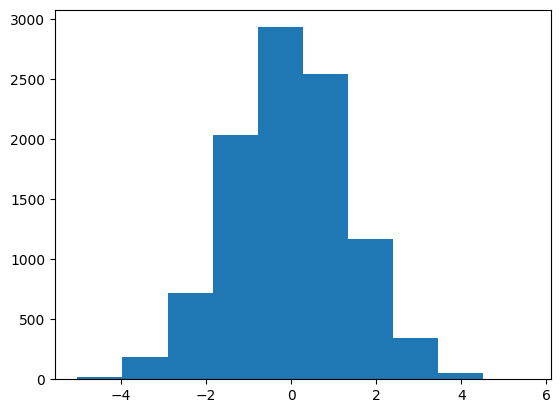

In [29]:
plt.hist(synth_data.iloc[:,1])
plt.show()

In [10]:
synth_data

,0,1
0,1.764052,0.400157
1,4.190537,2.903029
2,20.365068,2.650111
3,28.822182,11.386255
4,13.272542,22.292068
...,...,...
9995,5.497862,7.578495
9996,4.180604,10.290352
9997,1.140387,9.065211
9998,0.996105,6.358582


In [ ]:
def theory_bounds(marg_x, marg_y, thres_x, thres_y):

    p_x = np.mean(marg_x >= thres_x, axis=0)
    p_x_ctf = 1 - p_x
    p_y_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x_ctf = p_y_and_x_ctf/p_x_ctf

    p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x = p_y_and_x/p_x

    #print(p_y_given_x)
    p_l = p_y_given_x_ctf/p_y_given_x

    p_y_ctf_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y <= thres_y), axis=0)
    p_y_ctf_given_x_ctf = p_y_ctf_and_x_ctf/p_x_ctf

    p_r = p_y_ctf_given_x_ctf/p_y_given_x
    l_b = np.maximum(0, 1 - p_l)

    #right bound
    r_b = np.minimum(1, p_r)

    return l_b, r_b

In [19]:
window_size = 5
windows = np.lib.stride_tricks.sliding_window_view(synth_data.values, (window_size, synth_data.shape[1]))
# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, synth_data.shape[1])
marg_y_t_1 = windows[:,:-1,0]
marg_y_t = windows[:,1:,0]

thres_y_t_1 = 2
thres_y_t = 1

theory_bounds(marg_y_t_1, marg_y_t, thres_y_t_1, thres_y_t)

(array([0.78415974, 0.78429119, 0.78429119, 0.78414506]),
 array([0.9652345 , 0.96536595, 0.96536595, 0.96543161]))

In [ ]:
#windows[:-1], windows[1:]
#windows[1] thres_y_t

In [38]:
windows.shape

(9996, 5, 1)

In [69]:
#p_x = np.mean(marg_x >= thres_x, axis=0)
idx_win = 0
c_y_t_1 = 0
c_ctf_y_t_1 = 0
c_y_t_and_y_t_1 = 0
ctf_c_y_t_and_ctf_y_t_1 = 0
c_y_t_and_ctf_y_t_1 = 0
N = (windows.shape[0]-1)

for i in range(N):
    temp_y_t_1 = windows[i][idx_win]
    temp_y_t = windows[i+1][idx_win]

    if temp_y_t_1 >= thres_y_t_1:
        c_y_t_1 += 1

        if temp_y_t > thres_y_t:
            c_y_t_and_y_t_1 += 1
    
    if temp_y_t_1 < thres_y_t_1:
        c_ctf_y_t_1 += 1

        if temp_y_t > thres_y_t:
            c_y_t_and_ctf_y_t_1 += 1

    if temp_y_t_1 < thres_y_t_1:
        c_y_t_1 += 1

        if temp_y_t <= thres_y_t:
            ctf_c_y_t_and_ctf_y_t_1 += 1



In [70]:
P_y_x = (c_y_t_and_y_t_1/N)/(c_y_t_1/N)
P_y_ctf_x = (c_y_t_and_y_t_1/N)/(c_ctf_y_t_1/N)
P_ctf_y_ctf_x = (c_y_t_and_ctf_y_t_1/N)/(c_ctf_y_t_1/N)

In [74]:
max(0, 1 - P_y_ctf_x/P_y_x), min(1, P_ctf_y_ctf_x/P_y_x)

(0, 1)

In [27]:
marg_y_t

array([[ 1.29886375,  3.2799842 ,  4.49154535,  2.6159584 ],
       [ 3.2799842 ,  4.49154535,  2.6159584 ,  3.04285514],
       [ 4.49154535,  2.6159584 ,  3.04285514,  2.2829269 ],
       ...,
       [-0.01794176,  0.02800541,  0.53927651,  0.39850051],
       [ 0.02800541,  0.53927651,  0.39850051,  1.61691184],
       [ 0.53927651,  0.39850051,  1.61691184,  1.09141245]],
      shape=(9996, 4))

In [26]:
marg_y_t_1

array([[ 0.40015721,  1.29886375,  3.2799842 ,  4.49154535],
       [ 1.29886375,  3.2799842 ,  4.49154535,  2.6159584 ],
       [ 3.2799842 ,  4.49154535,  2.6159584 ,  3.04285514],
       ...,
       [ 2.23917492, -0.01794176,  0.02800541,  0.53927651],
       [-0.01794176,  0.02800541,  0.53927651,  0.39850051],
       [ 0.02800541,  0.53927651,  0.39850051,  1.61691184]],
      shape=(9996, 4))

In [25]:
np.mean(y_t(windows[:,:-2], np.random.normal(0,1,size=(9996)))>thres_y_t)

np.float64(0.2534387871461777)

In [18]:
window_size = 5
windows = np.lib.stride_tricks.sliding_window_view(cha.values, (window_size, cha.shape[1]))
# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, cha.shape[1])
marg_x = windows[:,:-1,0]
marg_y = windows[:,1:,1]


In [22]:
p_x = np.mean(marg_x >= thres_x, axis=0)
p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
p_y_given_x = p_y_and_x/p_x

In [23]:
p_y_given_x

array([0.96724046, 0.96724046, 0.96724046, 0.96723967])

In [7]:
synth_data

,0,1
0,1.764052,-0.202117
1,1.212072,3.426566
2,1.424152,4.565641
3,-1.791871,5.251605
4,-0.088043,-0.355819
...,...,...
9995,0.308665,-3.192229
9996,-0.105202,-0.979208
9997,-0.636937,0.306801
9998,0.273570,-2.577673


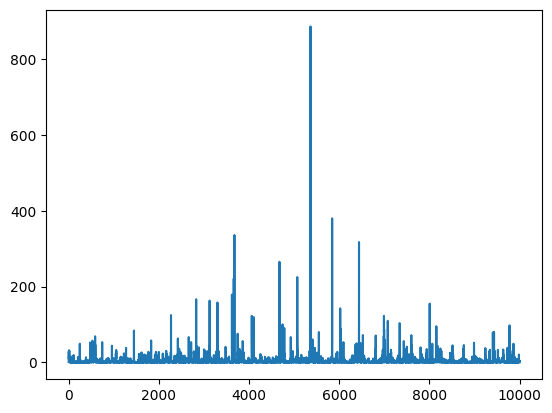

In [9]:
import matplotlib.pyplot as plt

plt.plot(synth_data[0.0])